In [1]:
import torch
import sys
import os
sys.path.append('../vega/')
import vega
import scanpy as sc
import scvi
from scipy import sparse
import numpy as np
import gseapy as gp
import pandas as pd
torch.manual_seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
path_to_save = '../paper/figures/kang_vega/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
font = {'family' : 'Arial',
        'size'   : 14}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
# Scanpy figures params
sc.set_figure_params(dpi_save=300)
sc.settings.figdir = path_to_save

In [2]:
model = vega.VEGA.load('../trained_models/kang_vega/')
print(model)

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
VEGA model with the following parameters: 
n_GMVs: 675, dropout_rate:0.5, z_dropout:0.5, beta:0.0001, positive_decoder:True
Model is trained: True


In [3]:
# Make names prettier and get names
model.adata.uns['_vega']['gmv_names'] = np.array([i if 'UNANNOTATED' in i else ' '.join(i.split('_')[1:]) for i in model.adata.uns['_vega']['gmv_names']])
gmv_names = model._get_gmv_names()

In [4]:
model.adata.obsm['X_vega'] = model.to_latent(return_mean=True)
sc.pp.neighbors(model.adata, use_rep='X_vega', n_neighbors=15)
sc.tl.umap(model.adata, min_dist=0.5, random_state=42)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


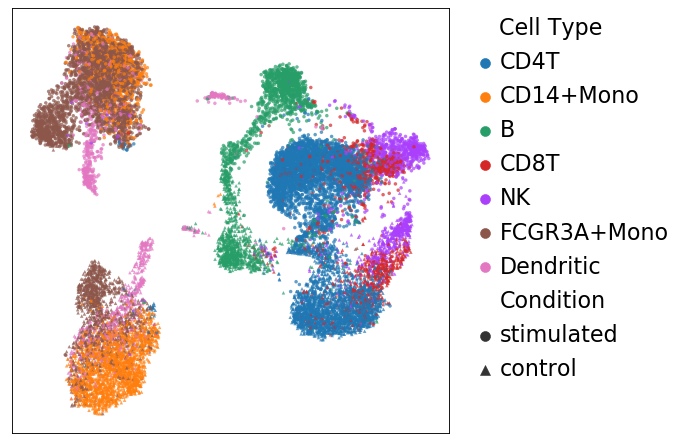

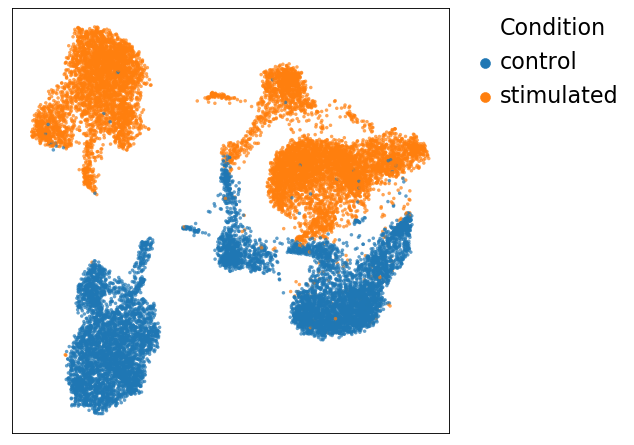

In [6]:
umap_df = pd.DataFrame({'UMAP-1':model.adata.obsm['X_umap'][:,0], 'UMAP-2':model.adata.obsm['X_umap'][:,1],
                        'Cell Type':model.adata.obs['cell_type'], 'Condition':model.adata.obs['condition']})

fig, ax = plt.subplots(figsize=[7,7])
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Cell Type', data=umap_df, style='Condition', markers=['o','^'],
                linewidth=0, alpha=0.7, s=10, cmap='tab10', hue_order=model.adata.obs['cell_type'].cat.categories,
                ax=ax, rasterized=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig(path_to_save+'umap_ct.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=[7,7])
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Condition', data=umap_df,
                linewidth=0, alpha=0.7, s=10, cmap='tab10', hue_order=model.adata.obs['condition'].cat.categories,
                ax=ax, rasterized=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig(path_to_save+'umap_cond.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


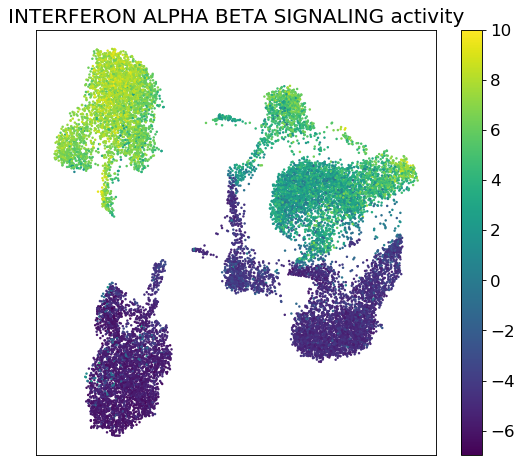

In [7]:
model.adata.obs['Interferon alpha beta signaling activity'] = model.adata.obsm['X_vega'][:,gmv_names.index('INTERFERON ALPHA BETA SIGNALING')]
#sc.pl.umap(model.adata, color='Interferon alpha beta signaling activity')
fig, ax = plt.subplots(figsize=[8,7])
sct = ax.scatter(model.adata.obsm['X_umap'][:,0], model.adata.obsm['X_umap'][:,1], alpha = 1, linewidths=0,
            c = model.adata.obs['Interferon alpha beta signaling activity'], marker='o', s=5, cmap = 'viridis', rasterized=True)
cbar = fig.colorbar(sct, ax=ax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
ax.set_title('INTERFERON ALPHA BETA SIGNALING activity', fontsize=18)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig(path_to_save+'umap_ifn.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [8]:
# vega.plotting.gmv_plot(model.adata,
#                        x='Interferon alpha beta signaling activity',
#                        y='Tryptophan catabolism activity', color='cell_type')
# vega.plotting.gmv_plot(model.adata,
#                        x='Interferon alpha beta signaling activity',
#                        y='Tryptophan catabolism activity', color='condition')

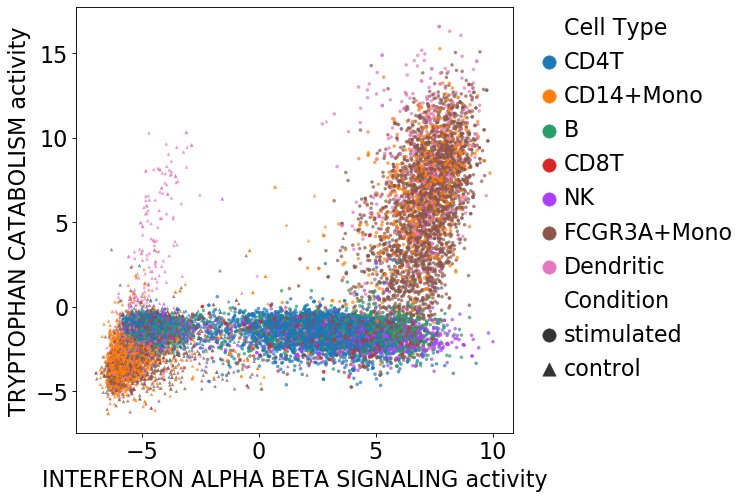

In [9]:
pathway_encoded_df = pd.DataFrame(data=model.adata.obsm['X_vega'], columns=gmv_names)
fig, ax = plt.subplots(figsize=[7,7])
sns.scatterplot(x=pathway_encoded_df['INTERFERON ALPHA BETA SIGNALING'].values,
            y=pathway_encoded_df['TRYPTOPHAN CATABOLISM'].values,
            hue=umap_df['Cell Type'], style=umap_df['Condition'], markers=['o','^'],
            linewidth=0, alpha=0.7, s=10, cmap='tab10', hue_order=model.adata.obs['cell_type'].cat.categories,
            ax=ax, rasterized=True)
ax.set_xlabel('INTERFERON ALPHA BETA SIGNALING activity',fontsize=20)
ax.set_ylabel('TRYPTOPHAN CATABOLISM activity',fontsize=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
ax.tick_params(labelsize=20)
ax.grid(False)
plt.savefig(path_to_save+'bivar_ifn_trp.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [10]:
adata_innate = model.adata[np.isin(model.adata.obs['cell_type'], ['CD14+Mono','FCGR3A+Mono', 'Dendritic']),:].copy()
model.differential_activity(adata = adata_innate,
                            groupby='condition',
                            group1='stimulated',
                            group2='control',
                            n_permutations=10000, n_samples=5000, random_seed=42)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


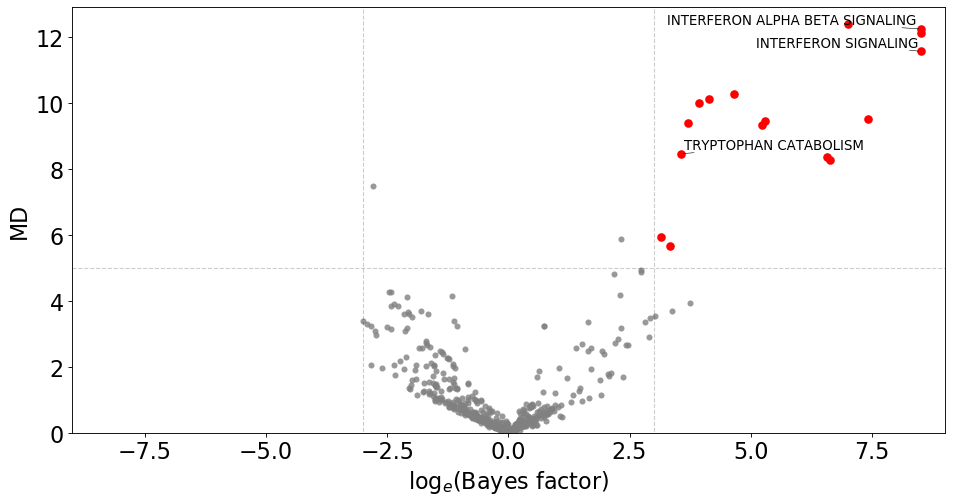

In [11]:
vega.plotting.volcano(adata_innate,
                      group1='stimulated',
                      group2='control',
                      sig_lvl=3.,
                      metric_lvl=5.,
                      annotate_gmv=['INTERFERON ALPHA BETA SIGNALING',
                                    'INTERFERON SIGNALING',
                                    'TRYPTOPHAN CATABOLISM'],
                     figsize=[14,7],
                     s=30,
                     fontsize=20,
                     textsize=12,
                     save=path_to_save+'volcano_innate.pdf')

In [12]:
adata_gs_innate = adata_innate.copy()

In [13]:
import gseapy as gp
sc.tl.rank_genes_groups(adata_gs_innate, groupby='condition', method='wilcoxon', n_genes=len(adata_gs_innate),
                        use_raw=True)
names = adata_gs_innate.uns['rank_genes_groups']['names']['stimulated']
scores = adata_gs_innate.uns['rank_genes_groups']['scores']['stimulated']
# Wrap
df = pd.DataFrame({'0':names, '1':scores})
df = df.sort_values(by=['1'], ascending=False)
pre_res = gp.prerank(rnk=df, gene_sets='../data/reactomes.gmt',
                     processes=4,
                     permutation_num=1000, min_size=5, max_size=1000, outdir=None)
gsea_res = pre_res.res2d
gsea_res.index = [i if 'UNANNOTATED' in i else ' '.join(i.split('_')[1:]) for i in gsea_res.index.tolist()]

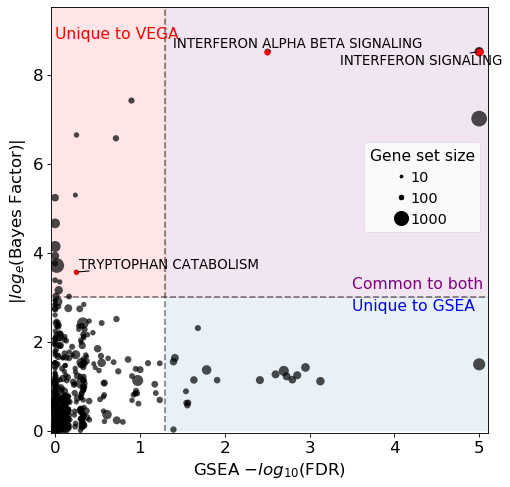

In [14]:
# Correlation plot GSEA -log10(FDR) / VAE |K|
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.lines import Line2D
from adjustText import adjust_text

pathway_dict = vega.utils._read_gmt('../data/reactomes.gmt')
n = model.add_nodes_
dfe_res = adata_innate.uns['_vega']['differential']['stimulated vs.control']
bf_cutoff = 3.
fdr_cutoff = -np.log10(0.05)

abs_bf = np.abs(dfe_res['bayes_factor'][:-n])
fdr_sorted = np.nan_to_num(-np.log10(np.nan_to_num(gsea_res.reindex(gmv_names[:-n])['fdr'],nan=1)), posinf=5)

p_sizes = np.array([len(v) for k,v in pathway_dict.items()])
# Rescale in range [10,100]
a,b = 20,200
dot_sizes = a + ((p_sizes - np.min(p_sizes))*(b-a))/(np.max(p_sizes)-np.min(p_sizes))


fig = plt.figure(figsize=[7,7])
plt.fill_between(np.linspace(fdr_cutoff,np.max(fdr_sorted)+0.1, 1000) , 0, bf_cutoff, color='C0', alpha=0.1,
                 interpolate=True)
plt.fill_between(np.linspace(fdr_cutoff,np.max(fdr_sorted)+0.1, 1000) , bf_cutoff, np.max(abs_bf)+1, color='purple', alpha=0.1,
                 interpolate=True)
plt.fill_between(np.linspace(-0.05,fdr_cutoff, 1000) , bf_cutoff, np.max(abs_bf)+1, color='r', alpha=0.1,
                 interpolate=True)


plt.hlines(xmin=np.min(fdr_sorted), xmax=np.max(fdr_sorted)+0.1, y=bf_cutoff, linestyle='--', color='k', alpha=0.5)
plt.vlines(ymin=np.min(abs_bf), ymax=np.max(abs_bf)+1, x=fdr_cutoff, linestyle='--',color='k', alpha=0.5)

plt.scatter(fdr_sorted, abs_bf, s=dot_sizes, c='k', linewidth=0, alpha=0.7)
texts = []
to_text = np.arange(len(dfe_res['bayes_factor']))[(np.abs(dfe_res['bayes_factor'])>bf_cutoff) & (np.abs(dfe_res['mad'])>3.)]
for i in to_text:
        name = gmv_names[i]
        if 'UNANNOTATED' not in name:
            x = fdr_sorted[i]
            y = dfe_res['bayes_factor'][i]
            #if y < 5.5:
            if 'INTERFERON' in name or 'TRYPTOPHAN' in name:
                texts.append(plt.text(x=x, y=y, s=name, fontdict={'size':12}))
                plt.scatter(x,y, s=dot_sizes[i], c='r', linewidth=0)
            

adjust_text(texts, only_move={'texts':'xy', 'arrows':'xy'}, arrowprops=dict(arrowstyle="-", color='k', lw=1))
plt.text(x=0, y=np.max(abs_bf)+0.3, s='Unique to VEGA', fontdict={'size':14, 'color':'r'})
plt.text(x=3.5, y=bf_cutoff+0.2, s='Common to both', fontdict={'size':14, 'color':'purple'})
plt.text(x=3.5, y=bf_cutoff-0.3, s='Unique to GSEA', fontdict={'size':14, 'color':'b'})
#plt.text(x=0.7, y=2., s='n.s', fontdict={'size':12, 'color':'k'})

plt.xlabel(r'GSEA $-log_{10}$(FDR)', fontsize=15)
plt.ylabel(r'$|log_e$(Bayes Factor)|', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([-0.05,np.max(abs_bf)+1])
plt.xlim([-0.05,np.max(fdr_sorted)+0.1])
plt.grid(False)
legend_sizes = a + ((np.array([10,100,1000]) - np.min(p_sizes))*(b-a))/(np.max(p_sizes)-np.min(p_sizes))
legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(10), markerfacecolor='k', markersize=np.sqrt(legend_sizes[0])),
                   Line2D([0], [0], marker='o', color='w', label=str(100), markerfacecolor='k', markersize=np.sqrt(legend_sizes[1])),
                   Line2D([0], [0], marker='o', color='w', label=str(1000), markerfacecolor='k', markersize=np.sqrt(legend_sizes[2]))]

plt.legend(handles=legend_elements, title='Gene set size', loc='best', bbox_to_anchor=[1, 0.7])
plt.savefig(path_to_save+'gsea_vs_bf.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [15]:
# T-test / BF comparison of activities
from scipy import stats
with np.errstate(invalid="ignore"):
                scores, pvals = stats.ttest_ind_from_stats(
                    mean1=np.mean(adata_innate.obsm['X_vega'][adata_innate.obs['condition']=='stimulated',:], axis=0),
                    std1=np.sqrt(np.var(adata_innate.obsm['X_vega'][adata_innate.obs['condition']=='stimulated',:], axis=0)),
                    nobs1=np.sum(adata_innate.obs['condition']=='stimulated'),
                    mean2=np.mean(adata_innate.obsm['X_vega'][adata_innate.obs['condition']=='control',:], axis=0),
                    std2=np.sqrt(np.var(adata_innate.obsm['X_vega'][adata_innate.obs['condition']=='control',:], axis=0)),
                    nobs2=np.sum(adata_innate.obs['condition']=='control'),
                    equal_var=False,  # Welch's
                )
from statsmodels.stats.multitest import multipletests
pvals[np.isnan(pvals)] = 1
_, pvals_adj, _, _ = multipletests(
    pvals, alpha=0.05, method='fdr_bh'
)
idx_nz = np.where(pvals_adj!=0)

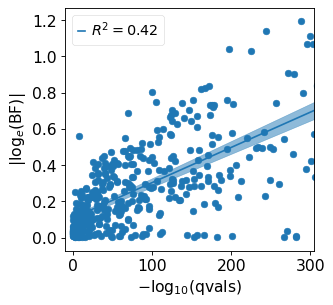

In [16]:
from scipy.stats import linregress
x = -np.log10(pvals_adj[idx_nz])
y = np.absolute(adata_innate.uns['_vega']['differential']['stimulated vs.control']['bayes_factor'])[idx_nz]
plt.scatter(x, y)
l = np.linspace(np.min(x), np.max(x), 1000)
res = linregress(x, y)
m, b, corr, p, m_std= res
b_std = res.intercept_stderr
plt.plot(l, m*l+b, label=r'$R^2=%.2f$'%corr**2)
plt.fill_between(l, (m-m_std)*l + (b-b_std), ((m+m_std)*l + (b+b_std)), color='C0', alpha=0.5)
plt.xlim([-10,305])
plt.xlabel(r'$-\log_{10}$(qvals)')
plt.ylabel(r'$|\log_e$(BF)|')
plt.grid(False)
plt.legend()
plt.show()
plt.close()


### Supplementary Figure 

#### 1 vs all cell type test

In [17]:
model.differential_activity(groupby='cell_type', n_permutations=10000, n_samples=5000, random_seed=0)

Using VEGA's adata attribute for differential analysis
No reference group: running 1-vs-rest analysis for .obs[cell_type]


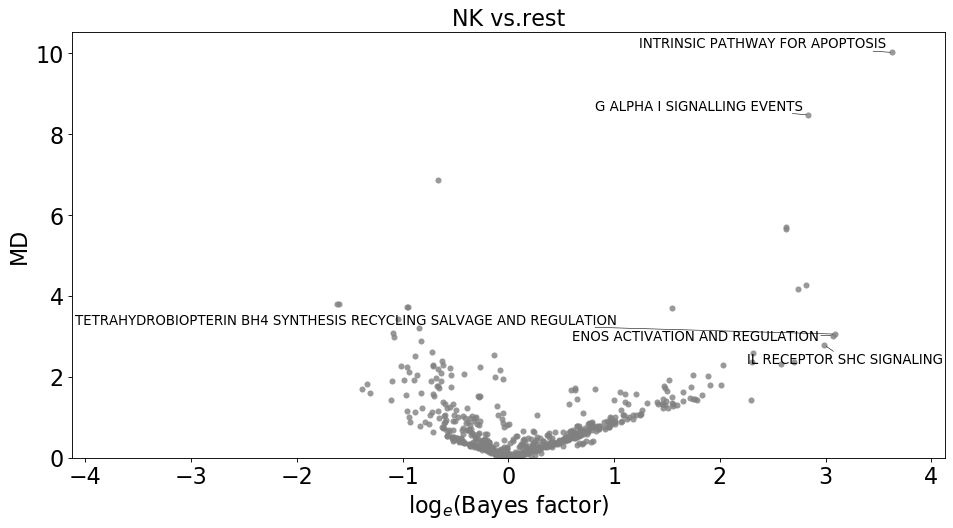

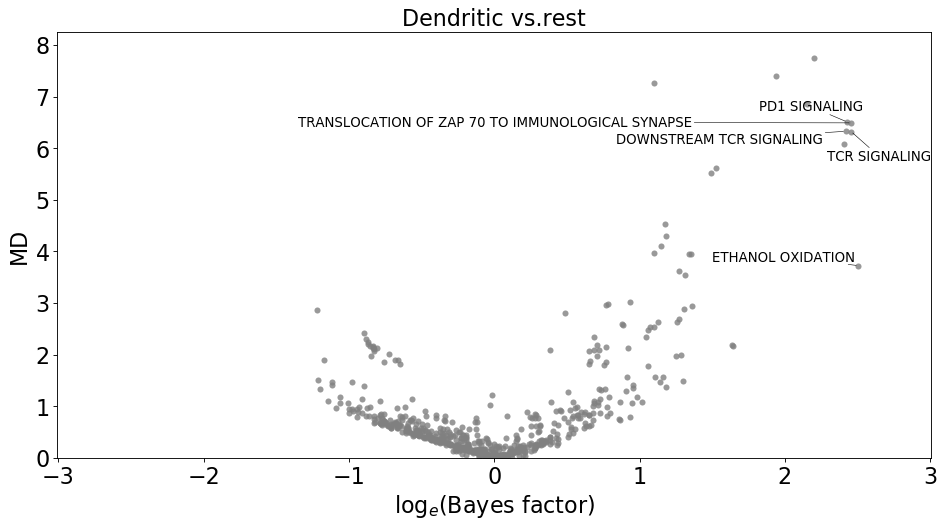

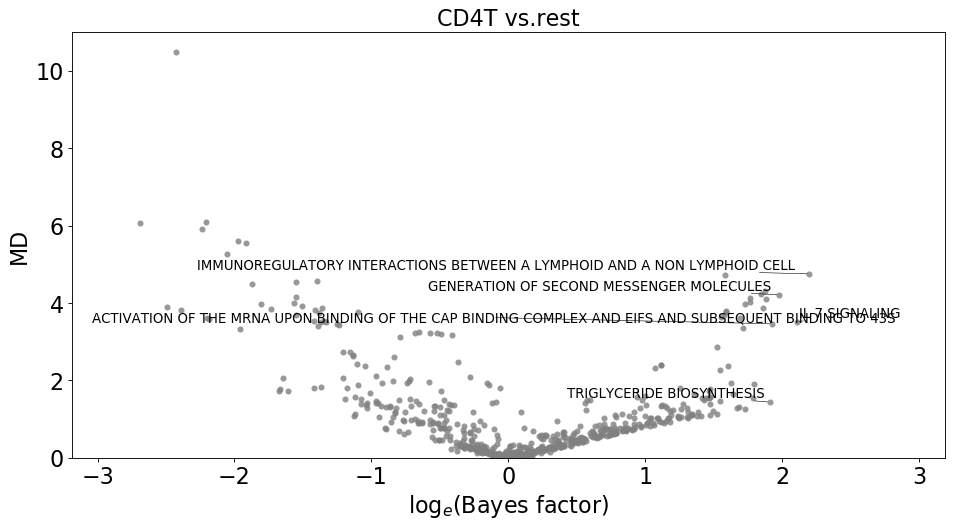

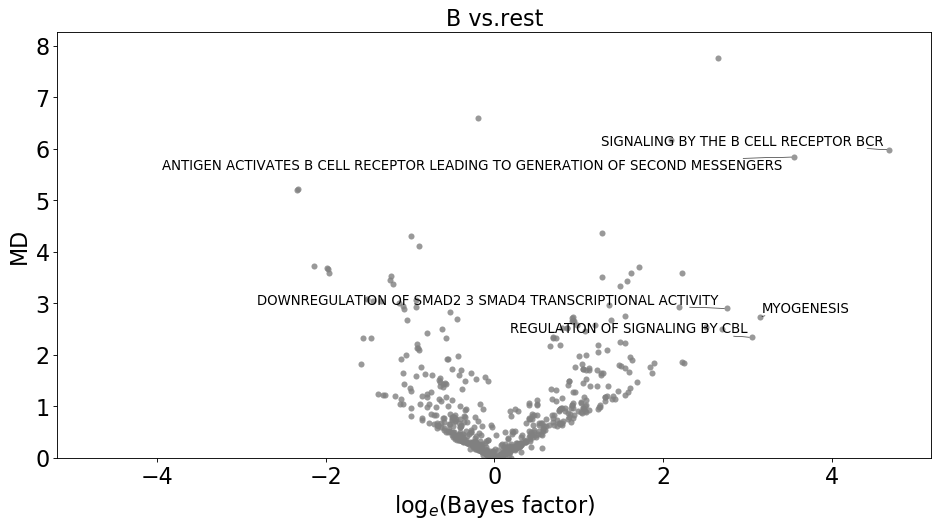

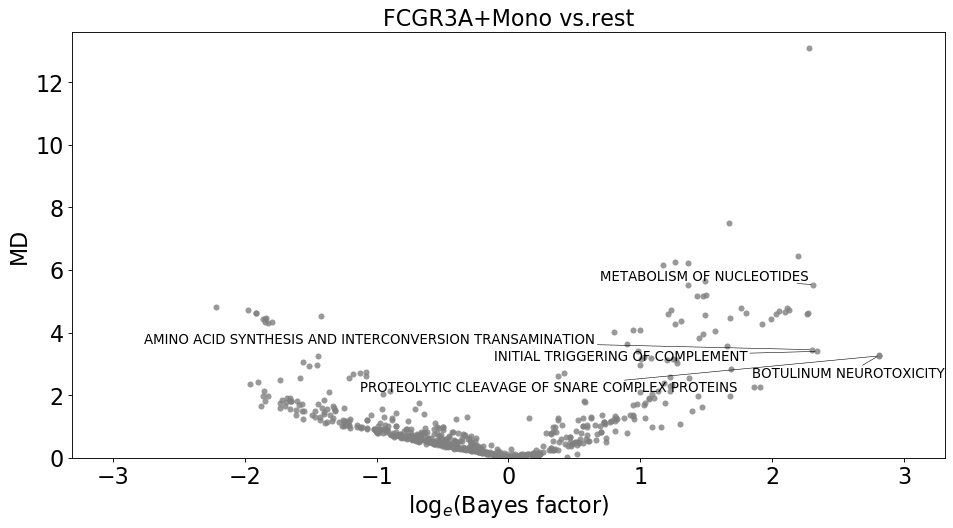

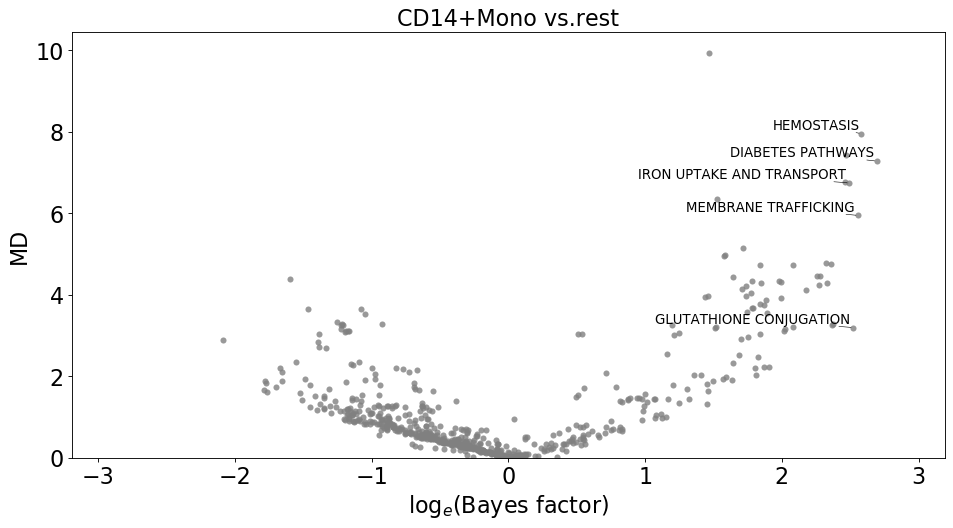

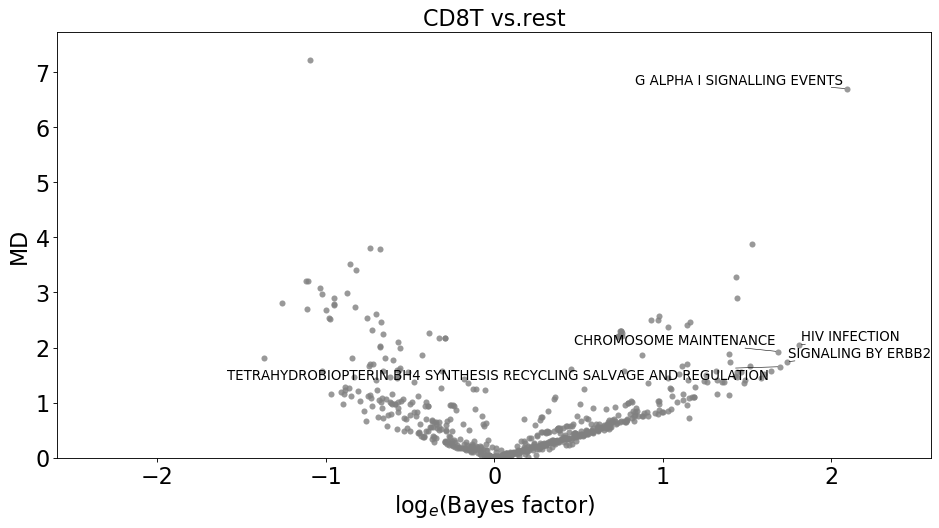

In [19]:
for k in model.adata.uns['_vega']['differential'].keys():
    g1, g2 = k.split(' vs.')
    to_annotate = model.adata.uns['_vega']['differential'][k]['bayes_factor']
    to_annotate = model.adata.uns['_vega']['gmv_names'][np.argsort(to_annotate)[::-1]][:5]
    vega.plotting.volcano(model.adata, group1=g1, group2=g2, figsize=[14,7], s=30, fontsize=20,textsize=12,
                          title=k, sig_lvl=100, metric_lvl=100,
                          annotate_gmv=list(to_annotate),
                          save=path_to_save+'_'.join([g1,g2])+'.pdf')

#### Gene set size bias

In [33]:
report_df = pd.DataFrame(index=gmv_names)
re_names = ['_'.join((['REACTOME']+list(i.split(' ')))) if 'UNANNOATED' not in i else i for i in report_df.index]
report_df['Bayes_Factor'] = dfe_res['bayes_factor']
report_df['Gene_set_size'] = [len(pathway_dict[i]) if i in pathway_dict else adata_innate.shape[1] for i in re_names]
report_df['GSEA_-log10FDR'] = np.nan_to_num(-np.log10(np.nan_to_num(gsea_res.reindex(gmv_names)['fdr'],nan=1.)), posinf=5.)

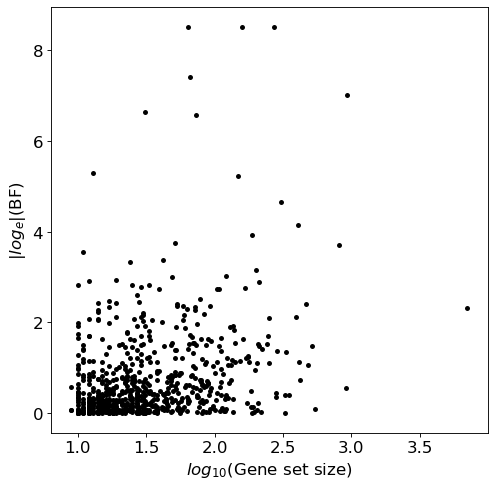

In [40]:
fig = plt.figure(figsize=[7,7])
plt.scatter(np.log10(report_df['Gene_set_size']), np.abs(report_df['Bayes_Factor']), s=20, linewidth=0, c='k')
plt.xlabel(r'$log_{10}$(Gene set size)', fontsize=15)
plt.ylabel(r'$|log_e|$(BF)', fontsize=15)
plt.grid(False)
#plt.ylim([0,8])
plt.tick_params(labelsize=15)
plt.savefig(path_to_save+'Supp_vega_bf_dist.pdf', format='pdf', dpi=300, bbox_inches='tight')

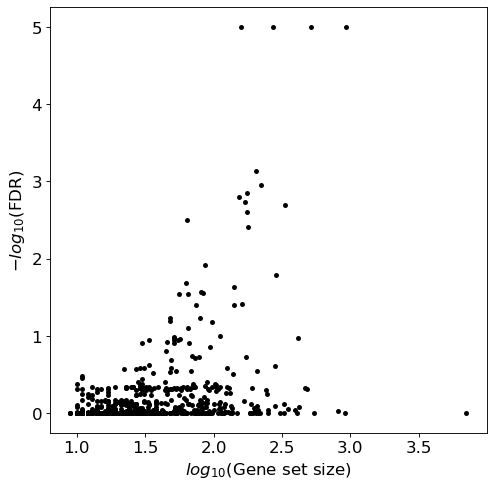

In [39]:
fig = plt.figure(figsize=[7,7])
plt.scatter(np.log10(report_df['Gene_set_size']), report_df['GSEA_-log10FDR'], s=20, linewidth=0, c='k')
plt.xlabel(r'$log_{10}$(Gene set size)', fontsize=15)
plt.ylabel(r'$-log_{10}$(FDR)', fontsize=15)
plt.grid(False)
plt.tick_params(labelsize=15)
plt.savefig(path_to_save+'Supp_gsea_fdr_dist.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [44]:
#  Save top 50 DA factors for each cell type
dict_top100 = {(i,j):[] for i in model.adata.obs['cell_type'].unique() for j in ['name','logBF']}
for k in dict_top100.keys():
    ct = k[0]
    t = k[1]
    s_idx = np.argsort(np.abs(model.adata.uns['_vega']['differential'][ct + ' vs.rest']['bayes_factor']))[::-1][:100]
    if t=='logBF':
        dict_top100[k] = model.adata.uns['_vega']['differential'][ct + ' vs.rest']['bayes_factor'][s_idx]
    else:
        names = np.array(gmv_names)[s_idx]
        dict_top100[k] = names
df_top100 = pd.DataFrame(dict_top100)
df_top100.to_csv('../paper/suppTable_top100DF_kang.csv', sep=',', index=True, header=True)

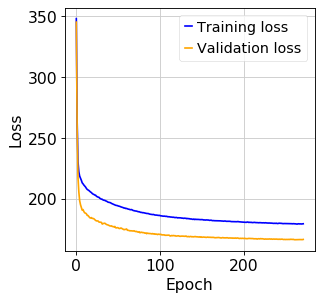

In [41]:
vega.plotting.loss(model)